# Evaluating Thermodynamic Functions

QWavE has also been implimented to obtain thermodynamic variables from the partition function (currently only the canonical partition function has been implimented). This example will show example on how to obtain Free Energies, entropies, and heat capacities.

# Canonical Partion Function

See the previus example titled ??? (coming soon) on how to obtain the canonical partition function. The free energy  ascociated with the canonical partition function is the Helmholtz free energy, and is obtained by:

$$A = {-k_{b} T} \text{ln}(q)$$

where $k_{b}$, $T$, and $q$ are the Boltzmann constant, temperature, and partition function respectively. The canonical partion is an $NVT$ ensemble, and thus the other thermodynamic quantities can be computed by taking the derivate of one of those parameters (as we shall see). Since this is a 1 dimensional solver, the volume should really be a length but this document will use both interchangably.

## Get the Helmholtz Free Energy

In [1]:
# Load some modules that will be needed
import qwave
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import gmpy2

In [2]:
bl = 10 # length of box
m = 1823 # mass of proton
temp = np.linspace(1,1000,1000) # temperature range, cannot evaluate the temperature at low T (working on a fix) 

# kb = constants.physical_constants['kelvin-hartree relationship'][0]
h_ev = constants.physical_constants['hartree-electron volt relationship'][0]
kb = constants.physical_constants['Boltzmann constant in eV/K'][0]

eigen,wave = qwave.schrodinger_solution(bl,m, problem='box')
eig = eigen * h_ev
q_can = qwave.q_PESq(eig,temp,kb) # the eigen values are in atomic units
                                         # you can convert them to another energy unit or leave them in atomic units if you wish

# you can evaluate A by hand via the equation above or use the free_A module for the same result 
# Helmholtz,S = qwave.free_A_S(q_can,temp,'eV')

In [6]:
q_tot = []
for i in temp:
    q_temp = 0
    for j in eig:
        q_temp = np.exp(-j/(kb*i)) + q_temp
        
    q_tot.append(q_temp)
# print(np.array(q_tot))

as=qwave.free_A(q_can,temp,kb)

In [4]:
num = np.exp(-eig[1]/(kb*100000))
den = 0
for i in eig:
    test = np.exp(-i/(kb*100000))
    den = den + test
    
num/den

0.1002900434613027

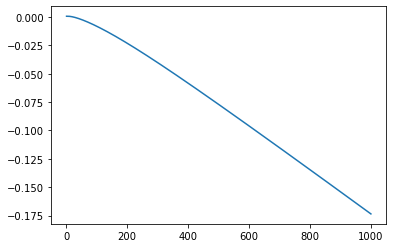

In [7]:
plt.plot(temp,as)

In [8]:
eig[0]/kb

8.406617071112892

In [14]:
# We will test the partition function modules on the C-Pt(100) example
import qwave
import csv 
from scipy import constants
import numpy as np


bohr_to_m = constants.physical_constants['Bohr radius'][0] # convert from bohr to meter
ang_to_m = constants.physical_constants['Angstrom star'][0] # convert from angstrom to meter

au_to_kg = constants.physical_constants['atomic unit of mass'][0]  # convert from au to kg
am_to_kg = constants.physical_constants['atomic mass constant'][0] # convert from am to kg

h_to_eV = constants.physical_constants['Hartree energy in eV'][0] # convert from Eh to eV

x=[] # store data in csv
y=[]

with open('./arbitrary.csv') as csvfile:                # read csvfile
    csvreader = csv.reader( csvfile,delimiter =',')
    for row in csvreader:
        x.append(float(row[0]))
        y.append(float(row[1]))

xdata = np.multiply(x,(ang_to_m/bohr_to_m))
ydata = np.multiply(y,1/h_to_eV)

results = np.vstack((xdata,ydata)).T

np.savetxt('./scaled-arbitrary.csv',results,delimiter=',')

bl = xdata[-1]-xdata[0]      # box length (centered at zerop)
m = 12 * (am_to_kg/au_to_kg) # atomic unit of mass of C atom
eigen,wave = qwave.schrodinger_solution(bl,m,
                                   pot_func='./scaled-arbitrary.csv',
                                   len_eigval = 10, 
                                #    unit='eV',
                                   problem='box')

# Now that we have the eigen values, we simply need to call the q_PESq() module, and 
# specify the eigen values, the temperature range, and the unit the eigenvalues are in.
# Note: you should look at the eigenvalues before evaluating anything and modify the 
# len_eigval parameter as needed. For this example we will just use the first 10 eigenvalues

temp = np.linspace(10,1200) # module will not work at very very low temperatures
Q_pesq = np.array(qwave.q_PESq(eigen,temp,'eV'))



TypeError: can't multiply sequence by non-int of type 'numpy.float64'

## q_HO

We have also implimented the ability to compute the partition function given the frequency for the harmonic oscillator. It work very similarly as the q_PESq() module, except it evaluates:

$$q_{\text{HO}} =\frac{\exp(\frac{h\nu}{2 k_{b} T})}{1-\exp(\frac{h\nu}{ k_{b} T})}$$

where $h$, and $\nu$ are Plancks constant and frequency (in cm-1) respectively. 

In [18]:
# We are going to make up a frequency here that is more intense than what we computed
# to illustrate a point made later

freq_inplane = 643 # in-plane frequency vibration (degenerate)
freq_normal = 249 # out-of-plane frequency vibration

Q_HO_in = qwave.q_HO(freq_inplane,temp,'eV',h_to_eV)
Q_HO_out = qwave.q_HO(freq_normal,temp,'eV',h_to_eV)

TypeError: can't multiply sequence by non-int of type 'numpy.float64'

With these partion functions, we can evaluate some thermodynamic properties

## free_A_S()

free_A_S() module computes the helmholtz free energy (which is the free energy which corresponds with this ensemble) and the entropy. These are computed as:

$$A = -k_{b}T\ln(\prod_{i=\text{DOF}}q_{i})$$
<br>
$$S = -\frac{\partial A}{\partial T}$$

where $i$ covers the availible degrees of freedom. Since we are dealing with a monatomic atom, all we have are the translations of the atom on the surface (translations in the x,y,z). Note 1: you can approximate these translations as frustrated vibrations on the surface. Note 2: for simplicity, we will assume that the motion normal to the surface can always be treated within the harmonic approximaiton, so $q_{z}$ will come from the freq_normal, but you are more than welcome to compute the out of plane potential and evaluate the eigenvalues for that potentials. Also we will assume that the in-plane motions are degenerate.

free_A_S() takes three parameters: q, temp, and unit. It returns both the free energy and entropy.

In [19]:
Q_HO_Tot = (Q_HO_in*Q_HO_in*Q_HO_out)
A_HO,S_HO = qwave.free_A_S(Q_HO_Tot,temp,'eV')

Q_PESq_Tot = (Q_pesq*Q_pesq*Q_HO_out)
A_PESq,S_PESq = qwave.free_A_S(Q_PESq_Tot,temp,'eV')

NameError: name 'Q_HO_in' is not defined

In [20]:
import matplotlib.pyplot as plt

plt.plot(temp,A_PESq*1000,linewidth=3,color='blue')
plt.plot(temp,A_HO*1000,linewidth=3,color='red')
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('A (meV)',size=14)
plt.xlabel('Temperature (K)',size=14)
plt.legend(['PESq model','HO model'],fontsize=14)
plt.show()

plt.plot(temp,S_PESq*1000,linewidth=3,color='blue')
plt.plot(temp,S_HO*1000,linewidth=3,color='red')
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylabel('S (meV/K)',size=14)
plt.xlabel('Temperature (K)',size=14)
plt.legend(['PESq model','HO model'],fontsize=14)
plt.show()

NameError: name 'A_PESq' is not defined

As you can see the harmonic oscillator model overestimate and underestimates the free energy and entropy respectively. The PESq model captures the full affect of anharmonic motions to calculate free energies and entropies. If we used the true frequency (543 cm-1) in the above calculations, the two lines would lie ontop of each other because the HO potential capture the actual potential very well (as seen in the other example notbook)

In [42]:
np.log(np.exp(-5e+325))

/afs/crc.nd.edu/user/c/cwaitt/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

In [37]:
np.exp(-np.nextafter(0,1))

1.0

In [34]:
np.nextafter(0,1)

5e-324

In [64]:
1.674e-27/9.109e-31

1837.7428916456254

In [68]:
kg_amu = constants.physical_constants['atomic mass constant'][0]
kg_au = constants.physical_constants['atomic unit of mass'][0]

1 * kg_amu /kg_au

1822.888486217313